In [9]:
import torch
from transformers import (AutoModelWithLMHead, 
                          AutoTokenizer, 
                          BertConfig,BertTokenizer,BertModel)
import matplotlib.pyplot as plt

In [2]:
# Load pre-trained model (weights)
config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True, output_attentions=True)
model = BertModel.from_pretrained('bert-base-uncased', config=config)
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [3]:
# Load pre-trained model tokenizer (vocabulary-multilingual)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
text = "My Name is Uttam Asodariya and I am a FAU student."
marked_text = "[CLS] " + text + " [SEP]"


tokenized_text = tokenizer.tokenize(marked_text) # Tokenize our sentence with the BERT tokenizer.
segments_ids = [1] * len(tokenized_text) #specify sentences with o and 1
segments_ids

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Print out the tokens.
print (tokenized_text)


['[CLS]', 'my', 'name', 'is', 'ut', '##tam', 'as', '##oda', '##ri', '##ya', 'and', 'i', 'am', 'a', 'fa', '##u', 'student', '.', '[SEP]']


In [5]:
# Convert inputs to PyTorch tensors, because our pretarained model required our data to be into torch tensor
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids]) 

In [6]:
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

In [7]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 19
Number of hidden units: 768


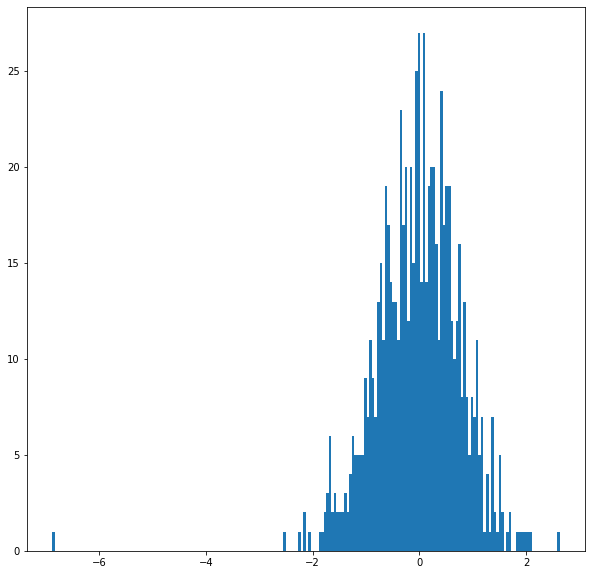

In [10]:
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [11]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 19, 768])


In [12]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 19, 768])

In [13]:
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 19, 768])

In [14]:
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([19, 13, 768])

In [20]:
# Would like individual vector for each token have 13 vector with 768 length. Not easy to create. Suitable approach concatenate
# Stores the token vectors, with shape [22 x 3,072]
# token_vecs_cat = []

# # `token_embeddings` is a [22 x 12 x 768] tensor.

# # For each token in the sentence...
# for token in token_embeddings:
    
#     # `token` is a [12 x 768] tensor

#     # Concatenate the vectors (that is, append them together) from the last 
#     # four layers.
#     # Each layer vector is 768 values, so `cat_vec` is length 3,072.
#     cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
#     # Use `cat_vec` to represent `token`.
#     token_vecs_cat.append(cat_vec)

# print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))


# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 19 x 768


In [21]:
#Make single vector for our sentence is to average of seconfd to last hidden layer.
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


In [22]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 my
2 name
3 is
4 ut
5 ##tam
6 as
7 ##oda
8 ##ri
9 ##ya
10 and
11 i
12 am
13 a
14 fa
15 ##u
16 student
17 .
18 [SEP]


In [24]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))


First 5 vector values for each instance of "bank".

bank vault    tensor([ 2.5867,  1.5666, -0.6096, -0.5176,  2.2265])
bank robber   tensor([ 1.0652,  1.4015, -3.0317,  0.4318,  1.5804])
